In [60]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import random
import os
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate
from datasets import load_dataset
from utils import *
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from utils import Word2Vec_Wrapper


# Preprocessing and model initialization

In [61]:
dataset = load_dataset("scikit-learn/imdb", split="train")
with open("config.yaml", 'r') as file:
        config = yaml.safe_load(file)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def load_model(Word2Vec_model_PATH, freeze=False):
    word2vec_ckpt = torch.load(Word2Vec_model_PATH, map_location=torch.device('mps'))
    pretrained_embd = word2vec_ckpt['in_embedding.weight']
    embedding_layer = nn.Embedding.from_pretrained(pretrained_embd, freeze=freeze)
    return embedding_layer
layer = load_model('model_dim-256-radius-10-ratio-4-batch-500-epoch-30.ckpt')


In [62]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=200, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The number of padding symbols depends on the kernel size.
        # It is important to ensure that we have always a sequence
        # as long as the kernel size.
        # ex: if ks=3, we add 1 padding before and one after.
        # The sentence "Great" becomes "<pad> Great <pad>"
        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )
        # The parameter for AdaptiveMaxPool1d is the "output size"
        # or the number of output values for a dimension.
        # Here it is one: we want to get the max for every components.
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)




class Conv1dClassifier_Word2Vec(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, word2vec_path, feature_size=200, kernel_size=3):
        super().__init__()
        self.feature_size = feature_size
        self.embeddings =load_model(word2vec_path, freeze= False)
        self.embedding_dim = self.embeddings.embedding_dim
        # The number of padding symbols depends on the kernel size.
        # It is important to ensure that we have always a sequence
        # as long as the kernel size.
        # ex: if ks=3, we add 1 padding before and one after.
        # The sentence "Great" becomes "<pad> Great <pad>"
        self.conv = nn.Conv1d(
            self.embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )
        # The parameter for AdaptiveMaxPool1d is the "output size"
        # or the number of output values for a dimension.
        # Here it is one: we want to get the max for every components.
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)


In [63]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_token"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_token": features["input_ids"], "label": label}


data_collator = DataCollator(tokenizer)

In [69]:
def preprocessing_fn(x, tokenizer):
    x["review_token"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x



n_samples = len(dataset) //2# the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_token", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

batch_size = 128

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [65]:
print(next(iter(train_dataloader)))

{'review_token': tensor([[ 1045,  2377,  2345,  ...,     0,     0,     0],
        [ 2023,  2003,  1037,  ...,     0,     0,     0],
        [ 1045,  2066,  2023,  ...,  2019, 17318,  3257],
        ...,
        [ 1006,  2017,  1005,  ...,     0,     0,     0],
        [10620,  4129,  1997,  ...,  1996,  6011, 15185],
        [ 5699,  1004, 17688,  ...,     0,     0,     0]]), 'label': tensor([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])}


# Comparison of all models

In [71]:
n_epochs = 10
def compute_accuracy(predictions, labels):
    pred = (predictions > 0.5).int()
    correct = (labels == pred).sum().item()
    return correct


def train_one_epoch(model, dataloader, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(torch.device('mps')) for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["review_token"])
        gold = batch["label"]

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


def validate_one_epoch(model, dataloader, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(torch.device('mps')) for k, v in batch.items()}
            probs = model(batch["review_token"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold.float())
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy

def train(model, n_epochs):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(n_epochs):
        train_avg_loss, train_avg_acc = train_one_epoch(
            model, train_dataloader, optimizer, loss_function
        )
        valid_avg_loss, valid_avg_acc = validate_one_epoch(
            model, valid_dataloader, loss_function
        )

        train_losses.append(train_avg_loss)
        valid_losses.append(valid_avg_loss)
        train_accs.append(train_avg_acc)
        valid_accs.append(valid_avg_acc)

        print(
            f"Epoch {epoch+1}/{n_epochs}",
            f"Train Loss: {train_avg_loss:.2f}",
            f"Train Acc: {train_avg_acc:.2f}%",
            f" | Valid Loss: {valid_avg_loss:.2f}",
            f"Valid Acc: {valid_avg_acc:.2f}%",
        )

    return train_losses, valid_losses, train_accs, valid_accs


valid_losses_table = []
valid_accs_table = []
train_losses_table = []
train_accs_table = []
for file in os.listdir(os.getcwd()):
    filename = os.fsdecode(file)
    if filename.endswith(".ckpt"):
        embedding_dim = int(filename.split("-")[1])
        R = int(filename.split("-")[3])
        print(embedding_dim, R)
        model = Conv1dClassifier_Word2Vec(word2vec_path= filename, feature_size=100, kernel_size=3).to(torch.device('mps'))
        train_losses, valid_losses, train_accs, valid_accs = train(model, n_epochs)
        valid_losses_table.append(valid_losses)
        valid_accs_table.append(valid_accs)
        train_losses_table.append(train_losses)
        train_accs_table.append(train_accs)


model = Conv1dClassifier(vocab_size= tokenizer.vocab_size + 1, embedding_dim=128, feature_size=100).to(torch.device('mps'))
train_losses, valid_losses, train_accs, valid_accs = train(model, n_epochs)
valid_losses_table.append(valid_losses)
valid_accs_table.append(valid_accs)
train_losses_table.append(train_losses)
train_accs_table.append(train_accs)
model = Conv1dClassifier(vocab_size= tokenizer.vocab_size + 1, embedding_dim=256, feature_size=100).to(torch.device('mps'))
train_losses, valid_losses, train_accs, valid_accs = train(model, n_epochs)
valid_losses_table.append(valid_losses)
valid_accs_table.append(valid_accs)
train_losses_table.append(train_losses)
train_accs_table.append(train_accs)


256 2


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.62 Train Acc: 64.81%  | Valid Loss: 0.47 Valid Acc: 79.58%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.41 Train Acc: 81.52%  | Valid Loss: 0.37 Valid Acc: 83.40%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.30 Train Acc: 87.38%  | Valid Loss: 0.34 Valid Acc: 84.64%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.22 Train Acc: 91.76%  | Valid Loss: 0.33 Valid Acc: 84.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.16 Train Acc: 94.72%  | Valid Loss: 0.34 Valid Acc: 84.70%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.11 Train Acc: 96.67%  | Valid Loss: 0.35 Valid Acc: 85.04%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.09 Train Acc: 97.28%  | Valid Loss: 0.35 Valid Acc: 85.00%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.07 Train Acc: 97.95%  | Valid Loss: 0.37 Valid Acc: 85.08%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.05 Train Acc: 98.61%  | Valid Loss: 0.39 Valid Acc: 84.72%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.04 Train Acc: 98.98%  | Valid Loss: 0.43 Valid Acc: 84.28%
128 5


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.67 Train Acc: 58.15%  | Valid Loss: 0.60 Valid Acc: 71.96%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.54 Train Acc: 74.02%  | Valid Loss: 0.48 Valid Acc: 77.40%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.41 Train Acc: 81.88%  | Valid Loss: 0.42 Valid Acc: 80.14%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.32 Train Acc: 87.27%  | Valid Loss: 0.39 Valid Acc: 81.30%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.24 Train Acc: 90.70%  | Valid Loss: 0.38 Valid Acc: 82.08%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.18 Train Acc: 93.36%  | Valid Loss: 0.38 Valid Acc: 82.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.14 Train Acc: 95.42%  | Valid Loss: 0.39 Valid Acc: 83.14%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.11 Train Acc: 96.52%  | Valid Loss: 0.40 Valid Acc: 82.98%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.08 Train Acc: 97.37%  | Valid Loss: 0.42 Valid Acc: 82.82%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.06 Train Acc: 98.28%  | Valid Loss: 0.45 Valid Acc: 82.44%
128 10


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.67 Train Acc: 57.94%  | Valid Loss: 0.61 Valid Acc: 71.62%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.53 Train Acc: 74.98%  | Valid Loss: 0.47 Valid Acc: 78.92%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.40 Train Acc: 82.54%  | Valid Loss: 0.41 Valid Acc: 81.20%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.31 Train Acc: 87.42%  | Valid Loss: 0.39 Valid Acc: 82.16%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.23 Train Acc: 91.08%  | Valid Loss: 0.38 Valid Acc: 82.58%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.19 Train Acc: 93.43%  | Valid Loss: 0.38 Valid Acc: 82.90%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.14 Train Acc: 95.40%  | Valid Loss: 0.39 Valid Acc: 83.02%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.10 Train Acc: 96.92%  | Valid Loss: 0.40 Valid Acc: 83.16%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.08 Train Acc: 97.61%  | Valid Loss: 0.42 Valid Acc: 82.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.07 Train Acc: 97.97%  | Valid Loss: 0.44 Valid Acc: 82.28%
256 5


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.61 Train Acc: 65.67%  | Valid Loss: 0.46 Valid Acc: 79.98%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.41 Train Acc: 81.83%  | Valid Loss: 0.38 Valid Acc: 82.94%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.30 Train Acc: 87.69%  | Valid Loss: 0.35 Valid Acc: 84.14%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.22 Train Acc: 91.89%  | Valid Loss: 0.34 Valid Acc: 84.76%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.15 Train Acc: 94.93%  | Valid Loss: 0.36 Valid Acc: 83.74%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.11 Train Acc: 96.59%  | Valid Loss: 0.35 Valid Acc: 85.28%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.08 Train Acc: 97.43%  | Valid Loss: 0.36 Valid Acc: 84.98%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.06 Train Acc: 98.31%  | Valid Loss: 0.37 Valid Acc: 85.04%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.04 Train Acc: 98.86%  | Valid Loss: 0.39 Valid Acc: 85.04%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.04 Train Acc: 99.06%  | Valid Loss: 0.43 Valid Acc: 84.20%
128 2


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.67 Train Acc: 57.65%  | Valid Loss: 0.62 Valid Acc: 72.22%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.54 Train Acc: 74.25%  | Valid Loss: 0.48 Valid Acc: 78.92%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.40 Train Acc: 82.47%  | Valid Loss: 0.41 Valid Acc: 81.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.31 Train Acc: 87.34%  | Valid Loss: 0.39 Valid Acc: 82.52%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.24 Train Acc: 90.75%  | Valid Loss: 0.38 Valid Acc: 82.92%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.18 Train Acc: 93.42%  | Valid Loss: 0.38 Valid Acc: 83.36%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.14 Train Acc: 95.53%  | Valid Loss: 0.39 Valid Acc: 83.20%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.11 Train Acc: 96.38%  | Valid Loss: 0.40 Valid Acc: 82.98%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.09 Train Acc: 97.22%  | Valid Loss: 0.41 Valid Acc: 82.86%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.07 Train Acc: 98.19%  | Valid Loss: 0.42 Valid Acc: 82.72%
256 10


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.61 Train Acc: 65.77%  | Valid Loss: 0.46 Valid Acc: 78.94%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.41 Train Acc: 81.83%  | Valid Loss: 0.37 Valid Acc: 83.30%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.30 Train Acc: 87.85%  | Valid Loss: 0.35 Valid Acc: 85.14%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.22 Train Acc: 92.05%  | Valid Loss: 0.33 Valid Acc: 85.38%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.15 Train Acc: 94.92%  | Valid Loss: 0.33 Valid Acc: 85.18%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.11 Train Acc: 96.57%  | Valid Loss: 0.34 Valid Acc: 85.28%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.08 Train Acc: 97.44%  | Valid Loss: 0.38 Valid Acc: 84.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.06 Train Acc: 98.25%  | Valid Loss: 0.37 Valid Acc: 85.40%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.04 Train Acc: 98.88%  | Valid Loss: 0.41 Valid Acc: 84.06%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.04 Train Acc: 99.07%  | Valid Loss: 0.44 Valid Acc: 83.98%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.63 Train Acc: 63.91%  | Valid Loss: 0.52 Valid Acc: 76.10%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.52 Train Acc: 74.27%  | Valid Loss: 0.44 Valid Acc: 80.06%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.45 Train Acc: 79.09%  | Valid Loss: 0.39 Valid Acc: 82.52%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.40 Train Acc: 81.42%  | Valid Loss: 0.37 Valid Acc: 83.70%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.36 Train Acc: 84.00%  | Valid Loss: 0.35 Valid Acc: 84.62%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.34 Train Acc: 85.20%  | Valid Loss: 0.34 Valid Acc: 84.76%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.31 Train Acc: 86.83%  | Valid Loss: 0.33 Valid Acc: 85.74%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.28 Train Acc: 88.09%  | Valid Loss: 0.32 Valid Acc: 85.62%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.25 Train Acc: 89.29%  | Valid Loss: 0.32 Valid Acc: 86.30%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.23 Train Acc: 90.60%  | Valid Loss: 0.32 Valid Acc: 86.18%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.61 Train Acc: 65.28%  | Valid Loss: 0.46 Valid Acc: 79.42%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.46 Train Acc: 77.25%  | Valid Loss: 0.40 Valid Acc: 82.30%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.40 Train Acc: 81.14%  | Valid Loss: 0.37 Valid Acc: 83.48%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.35 Train Acc: 84.24%  | Valid Loss: 0.35 Valid Acc: 84.68%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.32 Train Acc: 86.21%  | Valid Loss: 0.33 Valid Acc: 85.14%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.28 Train Acc: 88.33%  | Valid Loss: 0.32 Valid Acc: 85.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.25 Train Acc: 89.67%  | Valid Loss: 0.32 Valid Acc: 85.40%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.22 Train Acc: 91.22%  | Valid Loss: 0.32 Valid Acc: 85.92%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.19 Train Acc: 92.60%  | Valid Loss: 0.33 Valid Acc: 85.44%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.16 Train Acc: 93.86%  | Valid Loss: 0.33 Valid Acc: 86.18%


8 8 8


<Figure size 2000x500 with 0 Axes>

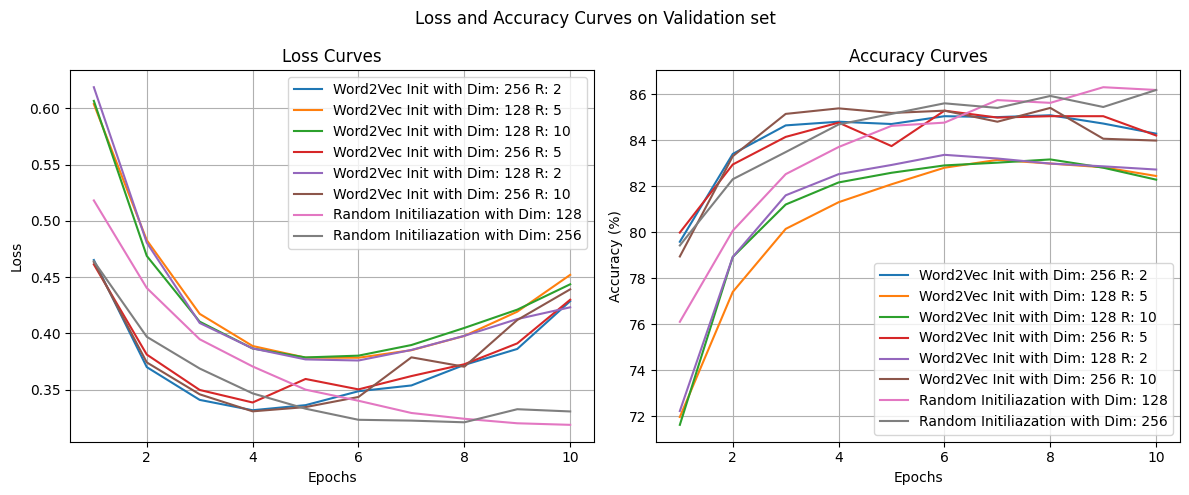

In [77]:
# Plotting Loss and Accuracy Curves
epochs_range = range(1, n_epochs + 1)
labels = []
for file in os.listdir(os.getcwd()):
    filename = os.fsdecode(file)
    if filename.endswith(".ckpt"):
        embedding_dim = int(filename.split("-")[1])
        R = int(filename.split("-")[3])
        labels.append(f"Word2Vec Init with Dim: {embedding_dim} R: {R}")

labels.append("Random Initiliazation with Dim: 128")
labels.append("Random Initiliazation with Dim: 256")

plt.figure(figsize=(20, 5))

print(len(valid_losses_table), len(labels), len(valid_accs_table))
# Loss plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(labels)):
    ax[0].plot(epochs_range, valid_losses_table[i], label= labels[i])
ax[0].set_title("Loss Curves")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

# Accuracy plot
for i in range(len(labels)):
    ax[1].plot(epochs_range, valid_accs_table[i], label= labels[i])
ax[1].set_title("Accuracy Curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()
ax[1].grid(True)
fig.suptitle("Loss and Accuracy Curves on Validation set")
fig.tight_layout()

plt.show()


<Figure size 2000x500 with 0 Axes>

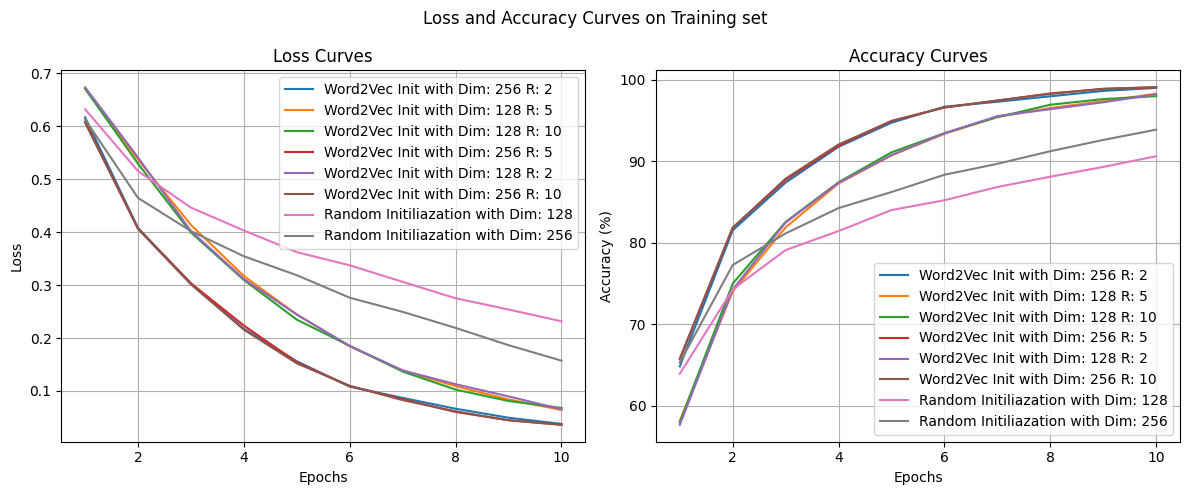

In [79]:
epochs_range = range(1, n_epochs + 1)
plt.figure(figsize=(20, 5))

# Loss plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(labels)):
    ax[0].plot(epochs_range, train_losses_table[i], label= labels[i])
ax[0].set_title("Loss Curves")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

# Accuracy plot
for i in range(len(labels)):
    ax[1].plot(epochs_range, train_accs_table[i], label= labels[i])
ax[1].set_title("Accuracy Curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()
ax[1].grid(True)
fig.suptitle("Loss and Accuracy Curves on Training set")
fig.tight_layout()
plt.tight_layout()
plt.show()

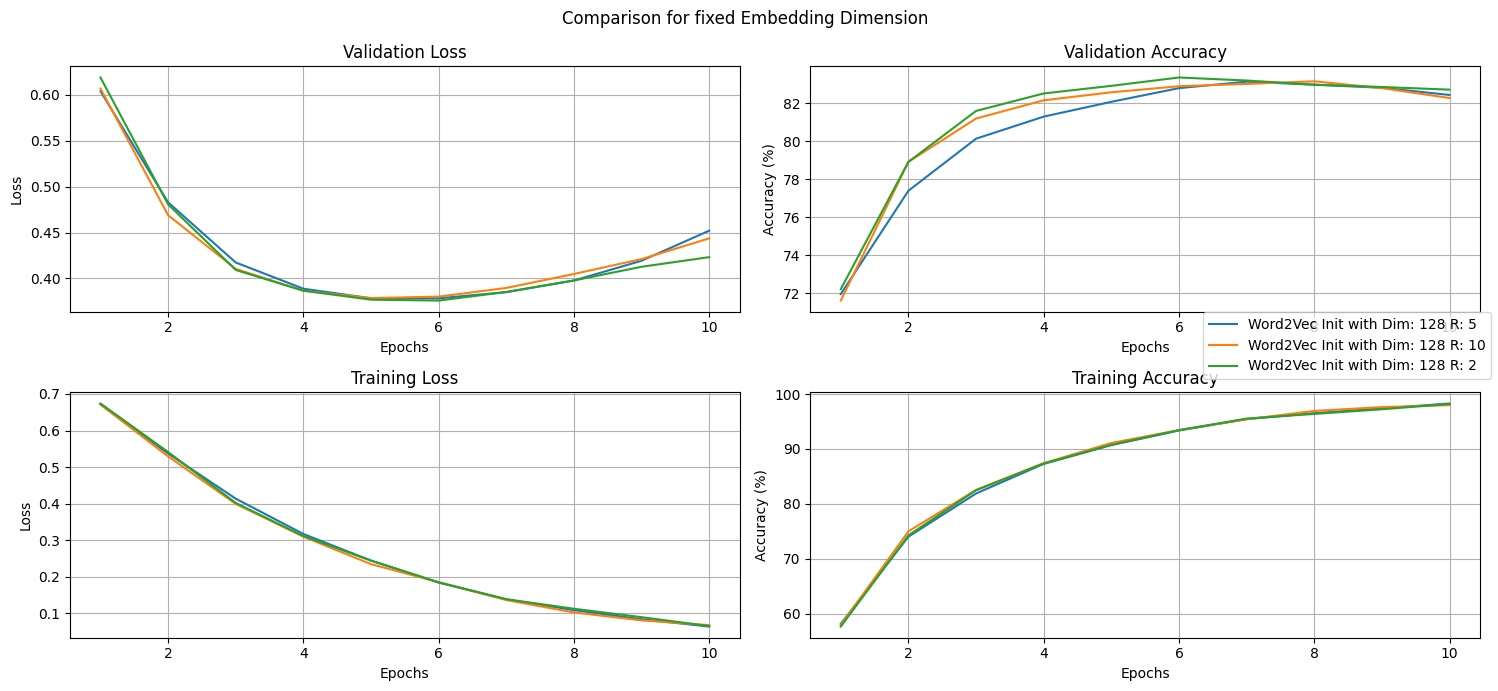

In [96]:
### Comparison for fixed Dimension

idx_to_keep =[]
idx = 0
for file in os.listdir(os.getcwd()):
    filename = os.fsdecode(file)
    if filename.endswith(".ckpt"):
        embedding_dim = int(filename.split("-")[1])
        if embedding_dim == 128:
            idx_to_keep.append(idx)
        idx += 1

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
for idx in idx_to_keep:
    ax[0, 0].plot(epochs_range, valid_losses_table[idx], label= labels[idx])
    ax[0, 1].plot(epochs_range, valid_accs_table[idx], label= labels[idx])
    ax[1, 0].plot(epochs_range, train_losses_table[idx], label= labels[idx])
    ax[1, 1].plot(epochs_range, train_accs_table[idx], label= labels[idx])
    ax[0, 0].set_title("Validation Loss")
    ax[0, 1].set_title("Validation Accuracy")
    ax[1, 0].set_title("Training Loss")
    ax[1, 1].set_title("Training Accuracy")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 1].set_xlabel("Epochs")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 1].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[1, 0].set_ylabel("Loss")
    ax[1, 1].set_ylabel("Accuracy (%)")
    ax[0, 0].grid(True)
    ax[0, 1].grid(True)
    ax[1, 0].grid(True)
    ax[1, 1].grid(True)

fig.legend(labels=[labels[idx] for idx in idx_to_keep], loc='center right')
fig.suptitle("Comparison for fixed Embedding Dimension")
fig.tight_layout()

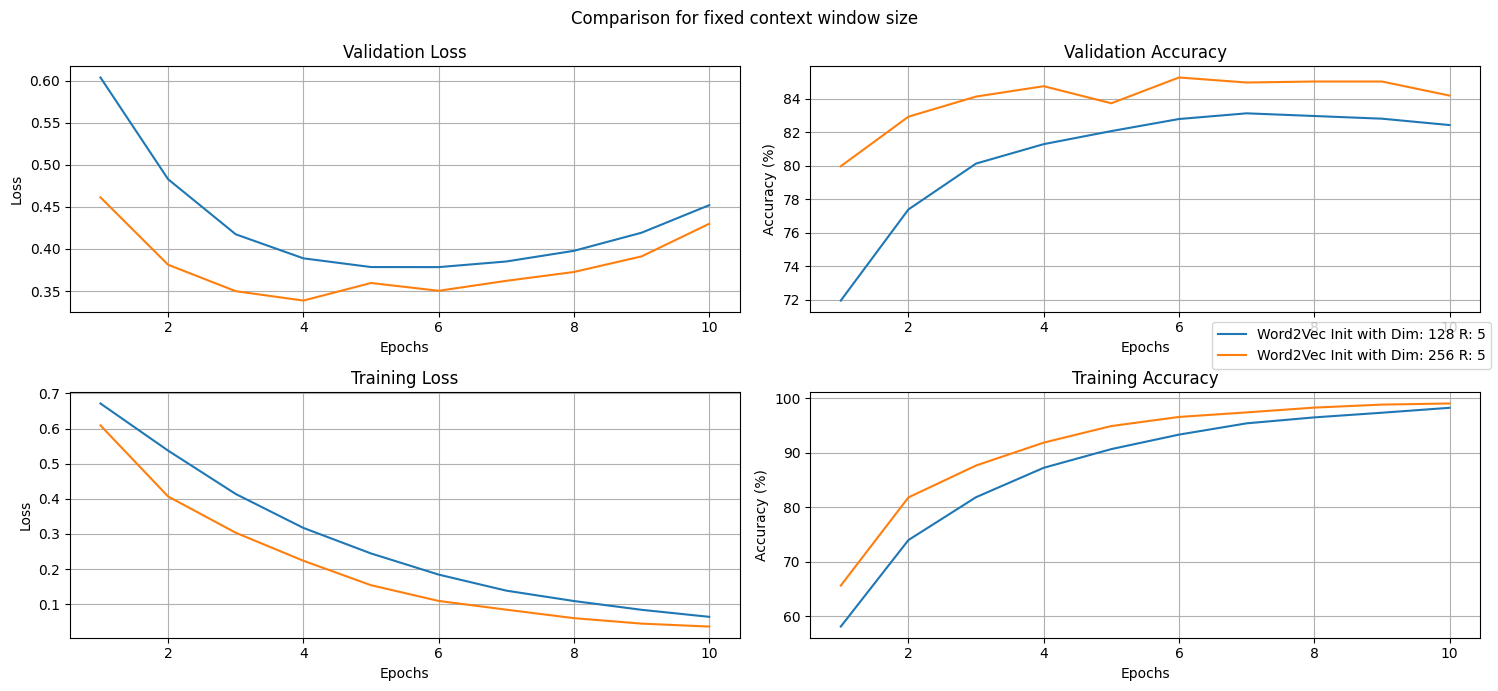

In [100]:
#Comparison for fixed R
idx_to_keep =[]
idx = 0
for file in os.listdir(os.getcwd()):
    filename = os.fsdecode(file)
    if filename.endswith(".ckpt"):
        R = int(filename.split("-")[3])
        if R == 5:
            idx_to_keep.append(idx)
        idx += 1

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
for idx in idx_to_keep:
    ax[0, 0].plot(epochs_range, valid_losses_table[idx], label= labels[idx])
    ax[0, 1].plot(epochs_range, valid_accs_table[idx], label= labels[idx])
    ax[1, 0].plot(epochs_range, train_losses_table[idx], label= labels[idx])
    ax[1, 1].plot(epochs_range, train_accs_table[idx], label= labels[idx])
    ax[0, 0].set_title("Validation Loss")
    ax[0, 1].set_title("Validation Accuracy")
    ax[1, 0].set_title("Training Loss")
    ax[1, 1].set_title("Training Accuracy")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 1].set_xlabel("Epochs")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 1].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[1, 0].set_ylabel("Loss")
    ax[1, 1].set_ylabel("Accuracy (%)")
    ax[0, 0].grid(True)
    ax[0, 1].grid(True)
    ax[1, 0].grid(True)
    ax[1, 1].grid(True)

fig.legend(labels=[labels[idx] for idx in idx_to_keep], loc='center right')
fig.suptitle("Comparison for fixed context window size")
fig.tight_layout()